# Sparse Method Algorithm for Research of Transcients Signal

Find transient source in data cubes

F. Acero, T. Stolarczyk, A. Chalumeau, Juin 2018

This notebook will:
1. Simulation (generate_cube_simu)
    - generate the fake data cubes (X,Y,T)
    - Filter the noise in the cubes with different methods
    - Find the peak (burst) in the data
    - Measure how well the methods performed
2. Produce diagnostic and result plots (plot_slice)

3. Produce performance plots based on Monte-Carlo

Some scenarios are considered: 
1. Transcient source position known:
    - Appearing in the FoV : known background
    - Generalist case : background evaluated online
2. Unknown position:
    - Wavelet cleaning

All the code is pure Python with the exception of the denoising step which requires the binary file msvst_2d1d.

In [1]:
%matplotlib inline
import pywi
from pywi.processing.transform import starlet
import scipy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm
import matplotlib.gridspec as gridspec
#from matplotlib.colors import Normalize

from gammapy.stats import significance
from gammapy.stats import significance_on_off

from astropy.convolution import convolve,convolve_fft,Gaussian1DKernel,Gaussian2DKernel,Tophat2DKernel
from astropy.visualization import simple_norm
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord,Angle
from astropy.wcs import WCS
import astropy.units as u
from astropy.table import Table

from scipy.stats import norm
from scipy import interpolate
from scipy.ndimage import zoom

from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact, fixed
import os,subprocess,sys,getpass,copy
import time as systime
import multiprocessing as mp
from functools import partial
from collections import defaultdict

#import line_profiler
#%load_ext line_profiler
#from scipy.stats import chisqprob
#from scipy.special import erfinv,erf,erfcx

import smartcube as smart
import scipy.integrate as sc

In [2]:
### Styles
# Define some plotting parameters and styles
#print(plt.style.available)
#plt.style.use('seaborn-talk')
plt.style.use('fast')

plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight']= 'bold'  # weight of the x and y labels
plt.rcParams['figure.titleweight']= 'bold'   # weight of the figure title
plt.rcParams['axes.labelsize']= 15
plt.rcParams['figure.titlesize']= 20
plt.rcParams['xtick.labelsize']= 12
plt.rcParams['ytick.labelsize']= 12
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['axes.grid']=True

In [3]:
#### Global variables and initialisations
# Path to the binary file - This is lame and adding the binary file to somewhere accesible by $PATH shoud be enough.
#prog='/Users/facero/Documents/Work/CTA/CTA-AIM/code/image-cleaning/msvst/build/msvst_2d1d'

user = getpass.getuser()
print("Defining variables for user",user)
exit
if (user=="achalume"):
    root_dir   = "/Users/achalume/Documents/Stage/Codes/" 
    bin_dir    = "/Users/achalume/Documents/Lib_files/Sparse2D/build/"
elif (user=="stolar"):
    root_dir   = "/home/stolar/Code/" 
    bin_dir    = root_dir + "bin/"
elif (user=="vheyraud"):
    root_dir = ("./")
    bin_dir    = "" 

#input_dir  = root_dir + "GRB-Fermi/FAWT3D/FermiData/"
#output_dir = root_dir + "GRB-Fermi/FAWT3D/output/"
#msvst      = bin_dir  + "msvst_2d1d"
#score_dir  = root_dir + "GRB-Fermi/FAWT3D/scores/"
#fig_dir    = root_dir + "GRB-Fermi/FAWT3D/Figures/"

input_dir  = root_dir
output_dir = "./bin/One_Trial/"
msvst      = "msvst_2d1d"#bin_dir
wave2D     = "./wl_t2_filter "
score_dir  = root_dir
fig_dir    = root_dir
acceptance_file = "Acceptance-LST-ctapipe.txt"

#### Check existences
if not os.path.exists(output_dir) :
    os.makedirs(output_dir)
if not os.path.exists(fig_dir) :
    os.makedirs(fig_dir)
if not os.path.exists(score_dir) :
    os.makedirs(score_dir)
    
print("Directories :")
print("    - Root              :",root_dir)
print("    - MSVST_2d1d binary :",bin_dir)
print("    - Input             :",input_dir)
print("    - Output            :",output_dir)
print("    - Scores            :",score_dir)
print("    - Figures           :",fig_dir)

Defining variables for user vheyraud
Directories :
    - Root              : ./
    - MSVST_2d1d binary : 
    - Input             : ./
    - Output            : ./bin/One_Trial/
    - Scores            : ./
    - Figures           : ./


# LC function

In [4]:
def LCBinChange(pre_t,pre_LC,fact_T_bin):
    """
    Re-bin a light curve multiplying the initial bin size with fact_T_bin. Returns : new_t,new_LC
    """
    
    alpha = fact_T_bin

    new_t = np.zeros(int(len(pre_t)/alpha)) ; new_LC = np.zeros(len(new_t))
    for i in range(0,len(new_t)):
        new_t[i] = pre_t[int(i*alpha)]
        new_LC[i] = np.sum(pre_LC[int((alpha*i)):int((alpha*i)+alpha)])

    return new_t,new_LC

############################################
def NormLC(LC,value,time,tmin,tmax):
    """
    Norm a range in a light curve (SUM(LC) = value from tmin to tmax). Returns : Normed_LC
    """
    LC_range = LC[np.where((time>=tmin) & (time<=tmax))]
    Normed_LC = value*LC/(np.sum(LC_range))
    
    return Normed_LC
                    
############################################
def InterpFunction(x_val,y_val,x_val_new):
    """
    Interpolate y(x) to get an approached function (y_new) with a given xtable (x_val_new). Returns : y_new
    """
    
    f = interpolate.interp1d(x_val,y_val)
    y_new = f(x_val_new)
    
    return y_new

############################################
def MakeLCTh(timebin,Xi,Tmintot,Tmaxtot,Ntotrange,Tminrange,Tmaxrange):
    """
    Make the theoretical LC normalizing at Ntotrange from Tminrange to Tmaxrange. Returns : Time, LC
    """
    
    T_0 = Tmintot
    Time = np.arange(Tmintot,Tmaxtot+timebin,timebin)
    K = (Tminrange**Xi)*(1+Xi)*Ntotrange/(Tmaxrange**(1+Xi) - Tminrange**(1+Xi))
    LC = K*Tminrange**(-Xi)*((Time)**(Xi+1)-(Time-timebin)**(Xi+1))/(Xi+1)
    
    return Time,LC
############################################
def MakeLCFa(datafile,Timebin,Bin_Factor,Ntotrange,Tminrange,Tmaxrange):
    """
    From Fabio's file, make LC normalizing at Ntotrange from Tminrange to Tmaxrange\
    choosing an initial bin size (Timebin). Returns : Time,LC
    """
    
    TimeData,LCData = np.loadtxt(datafile,unpack=True)
    Time = TimeData - TimeData[0] ; Time_size = TimeData[-1] - TimeData[0]   
    
    # Decrease time bin using an interpolation
    TimeInterp  = [x*Timebin for x in range(0,int(Time_size/Timebin),1)]
    TimeInterp = np.array(TimeInterp)
    LC = InterpFunction(Time,LCData,TimeInterp)
    
    LC_norm = NormLC(LC,Ntotrange,TimeInterp,Tminrange,Tmaxrange)
    T_input,LC_input = LCBinChange(TimeInterp,LC_norm,Bin_Factor) 
    
    return T_input,LC_input

############################################
def MakeLCIn(datafile,Timebin,Bin_Factor,Ntotrange,Tminrange,Tmaxrange):
    """
    From Inoue's extrapolated LC, make LC normalizing at Ntotrange from Tminrange to Tmaxrange.\
    Initial time bin (0.5) taken from the article. Returns : Time, LC
    """
    
    TData,LCData = np.genfromtxt(datafile,unpack=True,skip_header=6)

    # Set time values
    TData_0 = round(TData[0]) ; TData_end = np.round(TData[-1]/Timebin)*(Timebin)
    Time = np.linspace(TData_0,TData_end,len(TData))
    # Set LC values
    LC = LCData * Timebin # Put light curve in counts (it was in Cts/Bin before)
    LC = np.rint(LC).astype(int) # Set counts values

    T_input,LC_input = LCBinChange(Time,LC,Bin_Factor)
    LC_norm = NormLC(LC_input,Ntotrange,T_input,Tminrange,Tmaxrange)

    return T_input,LC_norm


# Cube fonctions

In [5]:
def BkgCube(time,SteadSrcPeak,bkg):
    """
    Creates the background model cube from a background value and a steady source peak.\
    Returns : BkgCube
    """
    BkgToycube = smart.CreateBkgModelCube(time,sigmaX,sigmaY,SteadSrcPeak,bkg,n2Dsize,pixelsize,Acceptance)
    BkgCube = smart.NoiseCube(BkgToycube)
    
    return BkgCube

############################################
def ImageCube(LC,time,SrcPeak,xcent,ycent,SteadSrcPeak,bkg):
    """
    Creates a cube containing bkg + transcient source. Returns : Fluctuated Signal+Bkg, Fluctuated Signal,Fluctuated Bkg
    """
    
    BkgToycube = smart.CreateBkgModelCube(time,sigmaX,sigmaY,SteadSrcPeak,bkg,n2Dsize,pixelsize,Acceptance)    
    
    #Create cubes' lists
    SrcCube = smart.CreateSignalModelCube(LC,SrcPeak,xcent,ycent,sigmaX,sigmaY,n2Dsize,pixelsize,Acceptance)
    SignalNoisyCube = smart.NoiseCube(SrcCube)
    BkgNoisyCube = smart.NoiseCube(BkgToycube)
    NoisyCube = SignalNoisyCube+BkgNoisyCube
    
    return (NoisyCube,SignalNoisyCube,BkgNoisyCube)

############################################
def BkgModelCube(time,tmin,tmax,tbin,SteadSrcPeak,bkg):
    """
    Create a bkg model cube (size = time) containing at each timebin the same image corresponding\
    to a perfectly known background. Returns : BkgModelCube
    
    Note : this function can be largely simplified, some parameters are useless (tmin,tmax,tbin..)
    """
        
    TimeAccum = np.arange(tmin,tmax+1,tbin)

    BkgToycube = smart.CreateBkgModelCube(TimeAccum,sigmaX,sigmaY,SteadSrcPeak,bkg,n2Dsize,pixelsize,Acceptance)
    
    #BkgNoisyCube = smart.NoiseCube(BkgToycube)
    BkgMeanImage = smart.CumulCube(BkgToycube)[:,:,-1]/(len(TimeAccum))
    
    BkgModelCube = np.zeros((len(BkgToycube[:,0,0]),len(BkgToycube[0,:,0]),len(time)))
    for t in range(0,len(time)):
        BkgModelCube[:,:,t] = BkgMeanImage
    
    return BkgModelCube

############################################
def BkgAcCube(tmin,tmax,tbin,SteadSrcPeak,bkg):
    """
    Create a bkg acquisition cube containing at each time bin the same image corresponding to
    and accumulated bkg from tmin to tmax(with tbins). Returns : BkgAcCue
    """
    TimeAccum = np.arange(tmin,tmax+1,tbin)
    
    BkgToycube = smart.CreateBkgModelCube(TimeAccum,sigmaX,sigmaY,SteadSrcPeak,bkg,n2Dsize,pixelsize,Acceptance)
    BkgNoisyCube = smart.NoiseCube(BkgToycube)

    return BkgNoisyCube

############################################
def WavCleaning(cube_noisy_file,wc_file,command):
    """
    Cube cleaning using wavelet transforms with msvst_2d1d (a shift is made to fix some argues,\
    maybe it should be seen better). Returns : Cube cleaned
    """
    
    cmd='%s  %s %s %s'%(msvst,command,cube_noisy_file,wc_file)
    subprocess.call(cmd,shell=True) # USE msvst_2d1d FILE

    #### Read wavelets cleaned cube file
    cube_wc,header_wc = smart.ReadCubeFromFile(wc_file,'fits')
    
    #### Cube shifting to fix msvst_2d1d's shift 
    cube_wc_shift = copy.deepcopy(cube_wc)
    cube_wc_shift[...,:-1] = cube_wc[...,1:] # Shift (time) to (time-1) (to see if its from msvst_2d1d)
    
    return cube_wc_shift

################################################
def WavCleaning2D(cube_noisy_file,wc_file,command):
    """
    Cube cleaning using wavelet transforms with mr_filter.
    Returns : Cube cleaned
    """
    
    cmd='%s  %s %s %s '%(wave2D,command,cube_noisy_file,wc_file)
    subprocess.call(cmd,shell=True)

    #### Read wavelets cleaned cube file
    cube_wc,header_wc = smart.ReadCubeFromFile(wc_file,'fits')
    
    return cube_wc
#################################################
def CreateAcceptance(flg,file):
    "flg = 0 : gaussian acceptance with width sigma_vig, flg = 1 interpolated acceptance from file"
    data = Table.read(filename=file,format="ascii")
    theta2 = data["theta2"]
    counts = data["counts"]
    Empirical = interpolate.interp1d(x=theta2,y=counts)
    x = np.linspace(0, n2Dsize-1, n2Dsize)
    y = np.linspace(0, n2Dsize-1, n2Dsize)
    x,y = np.meshgrid(x, y)
    Acceptance=np.empty((n2Dsize,n2Dsize))
    xo,yo=n2Dsize//2,n2Dsize//2
    
    if flg==0:
        Acceptance=np.exp( - ((x-xo)**2+(y-yo)**2)/(2*(sigma_vignetting/pixelsize)**2))
    if flg==1:
        theta2=((x-xo)**2+(y-yo)**2)*pixelsize**2
        theta2[xo,yo]=1# Necessary to avoid an error related to the interpolation error when theta2=0
        Acceptance=Empirical(theta2)
        Acceptance[xo,yo]=1# correct the value at the center
        #Acceptance=Empirical(((x-xo)**2+(y-yo)**2)*pixelsize**2+0.0002) : to use this we must add a small value cause the interpolation isn't defined in 0
    return Acceptance


# For performances

In [6]:
def ArrValMedian(Arr_val,percent):
    """
    Take an array or list, and gives the maximum value corresponding to the lowest (percent)% in all values.\
    Returns : Value
    """
    
    Arr_val = np.array(Arr_val)
    Arr_valsort = np.sort(Arr_val)
    Nth_val = int(percent*len(Arr_valsort))
    Value=np.nan
    if ~np.isnan(Arr_valsort[Nth_val-1]):
        Arr=Arr_valsort#[:Nth_val]
        Value=Arr[int(0.5*len(Arr))]#[:Nth_val]))]
    
    return Value

In [7]:
def DetectorEff(xp,yp):
    """
    Detector efficiency calculator at (xp,yp). Returns : Eff value 
    """
    
    x = np.linspace(0, n2Dsize-1, n2Dsize)
    y = np.linspace(0, n2Dsize-1, n2Dsize)
    x,y = np.meshgrid(x, y)
    
    # Create vignetting to be applied to image and transcient signal
    vign = smart.twoD_Gaussian(x, y, 1, n2Dsize/2,n2Dsize/2,\
                           sigma_vignetting/pixelsize, sigma_vignetting/pixelsize, 0, 0)
    Eff = vign[xp,yp]
    
    return Eff

# Instrument response function

In [8]:
FOV               = 4.5    #width in degrees
pixelsize         = 0.1   #in degrees
n2Dsize           = int(FOV/pixelsize)
sigma_vignetting  = 1.8    # (deg) from ctobssim
ct95 = 0.2
a = 0.95
sigma_PSF         = smart.sigma_from_containment_radius(ct95,a)   # (deg) Since the psf isn't a gaussian, we use half of the 95% containement radius and the shape of a gaussian
print(sigma_PSF)
background        = 0.04    # cts/s/pixel in E=50-500 GeV at center of FoV. Tbin=10s bkg=0.1
sigmaX, sigmaY   = float(sigma_PSF/pixelsize),  float(sigma_PSF/pixelsize) # Point like source
Acceptance=CreateAcceptance(0,acceptance_file)

print("Instrument response function")
print("----------------------------")
print("  Field of view       : ",FOV)
print("  Pixel size          : ",pixelsize)
print("  N. of pixels        : ",n2Dsize,"x",n2Dsize)
print("  Mean CTA background : ",background," (cts/s/pix, 50<E<500 GeV)")



0.081707796530727
Instrument response function
----------------------------
  Field of view       :  4.5
  Pixel size          :  0.1
  N. of pixels        :  45 x 45
  Mean CTA background :  0.04  (cts/s/pix, 50<E<500 GeV)


## For One Trial Analysis

In [73]:

def ImageRingSignif(Image,meth,FactOffIn,FactOffOut,Xcenter,Ycenter,Theta):
    """
    Returns the significance functions of a "cube image" knowing where is the source ; meth = 'lima', 'simple'
    """
    
    x = np.linspace(0,n2Dsize-1,n2Dsize)
    y = np.linspace(0,n2Dsize-1,n2Dsize)
    x,y = np.meshgrid(x, y)
    
    VignettingOut,VignettingOn = smart.SepSourceBkgImage(Acceptance,Xcenter,Ycenter,Theta)
    VignettingOff = smart.MakeRingImage\
        (Acceptance,Xcenter,Ycenter,FactOffIn,FactOffOut,Theta)
    MeanAcceptanceOn=np.nansum(VignettingOn)/np.size(VignettingOn[np.where(~np.isnan(VignettingOn))])
    MeanAcceptanceOff=np.nansum(VignettingOff)/np.size(VignettingOff[np.where(~np.isnan(VignettingOff))])
    
    ImageOut,ImageOn = smart.SepSourceBkgImage(Image,Xcenter,Ycenter,Theta)
    ImageOff = smart.MakeRingImage(Image,Xcenter,Ycenter,FactOffIn,FactOffOut,Theta)
    
    ton  = np.size(ImageOn[np.where(~np.isnan(ImageOn))])
    toff = np.size(ImageOff[np.where(~np.isnan(ImageOff))])
    alpha = (ton / toff)*(MeanAcceptanceOn / MeanAcceptanceOff)
    
    Non  = np.nansum(ImageOn)
    Noff = np.nansum(ImageOff)
    
    Signif = significance_on_off(n_on=Non,n_off=Noff,alpha=alpha, method=meth)
    return (Signif,Non,Noff,alpha)

############################################

def ImageReflectedSignif(Image,meth,XOn,YOn,Theta):
    """
    Returns the significance functions of a "cube image" knowing where is the source ; meth = 'lima', 'simple'
    """
    
    ImageOut,ImageOn = smart.SepSourceBkgImage(Image,XOn,YOn,Theta)
    Non = np.nansum(ImageOn)
    Xcen = n2Dsize/2 ; Ycen = n2Dsize/2
    DistOn = smart.ImageDistance(XOn,YOn,Xcen,Ycen)
    FactOn=np.arctan2(YOn-Ycen,XOn-Xcen)
    
    d = 5 # distance between 2 circles' centers are 3xradius
    radius = Theta
    Circ = 2*np.pi*DistOn
    NOffRegions = int(Circ/(d*radius))
    ImageOff = {}
    Noff = np.zeros(abs(NOffRegions))
    for i in range(1,NOffRegions+1):  
        Xnew = Xcen + DistOn*np.cos(FactOn+(i*2*np.pi/(NOffRegions+1)))
        Ynew = Xcen + DistOn*np.sin(FactOn+(i*2*np.pi/(NOffRegions+1)))
        ImageOut2,ImageOff[i] = smart.SepSourceBkgImage(Image,Xnew,Ynew,Theta)
        Noff[i-1] = np.nansum(ImageOff[i])
    if NOffRegions==0:
        Signif=0
        Alpha=np.nan
    else:
        Signif = significance_on_off(Non,np.nansum(Noff),alpha=1/NOffRegions,method=meth)
        Alpha=1/NOffRegions
    return (Signif,Non,np.nansum(Noff),Alpha)

##############################################

def Cube2DAnalyse(cube,T_new,method,xsrc,ysrc,factin=3/2,factout=5/2,Theta=float(ct95/pixelsize),cubemodel=0,cubebkgac=0,meth='lima',Tmaxbkg=60,Tminbkg=0,Tbinbkg=4):
    """
    Input : cube (CUMULATED) ; cubebkgacfile or cubemodel (NOT CUMULATED) ; method = 'reflected','ring','ROI vs FOV','acquired bkg'; facton : determines the On area radius, r=facton*psf ; factin : for ring method determine the in-raidus ;
    factout : dertmine th out-radius ; xsrc and ysrc give the source position (for relfected); Xtheta and Ytheta ; meth : significance_on_off gammapy parameter (lima or simple)
    method = 'reflected','ring','ROI vs FOV','acquired bkg','model bkg'
    
    Default values :  factin = 3/2,factout = 5/2, xsrc,ysrc = n2Dsize/2,n2Dsize/2, Theta=float(containment radius 95/pixelsize), cubebkgacfile = './', meth='lima'
    """
    
    Signif,Non,Noff,Alpha = [],[],[],[]
    
    if method=='ring':
        
        for t in range(0,len(cube[0,0,:])):
            Datas=ImageRingSignif(Image=cube[:,:,t],meth=meth,FactOffIn=factin,FactOffOut=factout,Xcenter=xsrc[t],Ycenter=ysrc[t],Theta=Theta)
            Signif.append(Datas[0])
            Non.append(Datas[1])
            Noff.append(Datas[2])
        Alpha = np.full(len(cube[0,0,:]),Datas[3])
                
    elif method=='reflected':
                        
        for t in range(0,len(cube[0,0,:])):
            Datas=ImageReflectedSignif(cube[:,:,t],meth,xsrc[t],ysrc[t],Theta)
            Signif.append(Datas[0])
            Non.append(Datas[1])
            Noff.append(Datas[2])
        Alpha = np.full(len(cube[0,0,:]),Datas[3])
        
    elif method=='ROI vs FOV':
        for t in range(0,len(cube[0,0,:])):
            SourceOut,SourceIn = smart.SepSourceBkgImage(cube,xsrc[t],ysrc[t],Theta)
            Non.append(np.nansum(SourceIn))
            Noff.append(np.nansum(SourceOut))
            Alpha.append(np.size(SourceIn[np.where(~np.isnan(SourceIn))])/np.size(SourceOut[np.where(~np.isnan(SourceOut))]))
        for i in range(len(Noff)):
            if Noff[i]!=0:
                Signif.append(significance_on_off(n_on=Non[i],n_off=Noff[i],alpha=Alpha[i],method=meth))
            else :
                Signif.append(scipy.stats.norm.ppf(1-0.5*np.exp(-Non[i])))
                    
                        
    elif method=='acquired bkg':
        for t in range(0,len(cube[0,0,:])):                
            SourceOut,SourceIn = smart.SepSourceBkgImage(cube,xsrc[t],ysrc[t],Theta)
            BkgAcOut,BkgAcIn = smart.SepSourceBkgCube(cubebkgac,xsrc[t],ysrc[t],Theta)
            Non.append(np.nansum(SourceIn[:,:,t]))
            Noff.append(np.nansum(BkgAcIn))
            Alpha.append((t+1)*(T_new[1]-T_new[0])/(TmaxBkg-Tminbkg))
        Signif = significance_on_off(n_on=Non,n_off=Noff,alpha=Alpha,method=meth)
        
    elif method=='model bkg':
        for t in range(0,len(cube[0,0,:])):                
            SourceOut,SourceIn = smart.SepSourceBkgImage(cube,xsrc[t],ysrc[t],Theta)
            BkgModelOut,BkgModelIn = smart.SepSourceBkgCube(cubemodel,xsrc[t],ysrc[t],Theta)
            Non.append(np.nansum(SourceIn[:,:,t]))
            Noff.append(np.nansum(BkgModelIn[:,:,:t]))
        for i in range(len(T_new)):
            Alpha.append(1)
        Signif = significance(n_on=Non,mu_bkg=Noff)
    
    elif method=='no bkg':
        for t in range(0,len(cube[0,0,:])):
            SourceOut,SourceIn = smart.SepSourceBkgCube(cube,xsrc[t],ysrc[t],Theta)
            Non.append(np.nansum(SourceIn[:,:,t]))
            Noff.append(0)
            Alpha.append(np.nan)
        for i in range(len(Noff)):
            if Non[i]>3:
                Signif.append(100)
            else:
                Signif.append(0)
                
        #Signif.append(scipy.stats.norm.ppf(1-0.5*np.exp(-Non[i])))
    Signif = np.array(Signif)
    Non = np.array(Non)
    Noff = np.array(Noff)
    Alpha=np.array(Alpha)
    return(Signif,Non,Noff,Alpha)

##############################################


def DiagnosticPlot(SigmaLim,T_new,LC_Src,Signif,Non,Noff,RealSignal,RealBackground,Alpha,shape):

    limit=np.full(len(T_new),SigmaLim)
    fig,ax=plt.subplots(6,figsize=shape)
    ax[0].plot(T_new,Signif,label='LiMa on/off significance',color='forestgreen')
    ax[0].plot(T_new,Signif,'.',color='forestgreen')
    ax[0].plot(T_new,limit,'_',label='Sigma limit',color='black')
    ax[0].legend()
    ax[0].set_title('Significance',fontsize=18)
    ax[1].plot(T_new,Non-Alpha*Noff,label='Signal',color='b')
    ax[1].plot(T_new,Non-Alpha*Noff,'.',color='b')
    ax[1].legend()
    ax[1].set_title('Signal',fontsize=18)
    ax[2].plot(T_new,RealSignal,label='Real Signal',color='black')
    ax[2].plot(T_new,RealSignal,'.',color='black')
    ax[2].legend()
    ax[2].set_title('Real Signal',fontsize=18)
    ax[3].plot(T_new,Alpha*Noff,label='Background',color='r')
    ax[3].plot(T_new,Alpha*Noff,'.',color='r')
    ax[3].legend()
    ax[3].set_title('Background',fontsize=18)                
    ax[4].plot(T_new,RealBkg,label='Real Bkg',color='black')
    ax[4].plot(T_new,RealBkg,'.',color='black')
    ax[4].legend()
    ax[4].set_title('Real Background',fontsize=18)   
    ax[5].plot(T_new,LC_Src,label='Injected signal',color='orange')
    ax[5].plot(T_new,LC_Src,'.',color='orange')
    ax[5].legend()
    ax[5].set_title('Injected Signal',fontsize=18)
    #ax[5].plot(T_new,Non,label='Non',color='green')
    #ax[5].plot(T_new,Non,'.',color='green')
    #ax[5].legend()
    #ax[6].plot(T_new,Noff,label='Noff',color='green')
    #ax[6].plot(T_new,Noff,'.',color='green')
    #ax[6].legend()
    #ax[7].plot(T_new,LC_Src,label='Injected signal',color='orange')
    #ax[7].plot(T_new,LC_Src,'.',color='orange')
    #ax[7].legend()
    plt.tight_layout()
    plt.show()
    print('Alpha = ',Alpha)

#######################################

def SelectTimes(T_new,Signif,SignifMin,RedFact,N):
    """
    Input : Time, Significance over time for one trial, significance threshold
    Outpout : list of the times for which the significance is over the threshold
    """
    t_min=[]
    for i in range(N):
        Sig=np.array(Signif[RedFact,i])
        T=T_new[np.where(~np.isnan(Sig))]
        S=Sig[np.where(~np.isnan(Sig))]
        T_good = T[np.where(S>=SignifMin)]
        if T_good.size > 0 : t_min.append(np.min(T_good))
        else : t_min.append(np.float('nan'))
    tmin_values = np.array(t_min)
    
    return(tmin_values)

##########################################################################################

def SearchMax(cube,meth='no smoothing',sigma_psf=sigma_PSF,pixelsize=pixelsize):
    test=copy.deepcopy(cube)
    index_max=np.empty((2,len(cube[0,0,:])))
    if meth=='smoothing':
        for i in range(np.shape(cube)[2]):
            test[:,:,i]=convolve_fft(test[:,:,i],Gaussian2DKernel(sigma_psf/pixelsize))
    for i in range(np.shape(cube)[2]):
        index_temp=np.unravel_index(np.argmax(test[:,:,i]),np.shape(test[:,:,i]))##return (x_assessed,y_assessed)
        index_max[0,i]=index_temp[0]
        index_max[1,i]=index_temp[1]
    return(index_max)
                        

In [58]:
## Plot 3D view of a Cube

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from mpl_toolkits.mplot3d import Axes3D


def Plot3DImage(cube,time,theta_view,phi_view,n2Dsize,figuresize):
    image=cube[:,:,np.where(time==T_new)[0][0]]
    fig = plt.figure(figsize=figuresize)
    ax = fig.add_subplot(111, projection='3d')
    X=np.linspace(0,n2Dsize,n2Dsize)
    Y=np.linspace(0,n2Dsize,n2Dsize)
    X,Y=np.meshgrid(X,Y)
    ax.plot_surface(X=X,Y=Y,Z=image,rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
    ax.view_init(theta_view,phi_view)
    plt.show()
    return

#Plot3DImage(image=CubeC[1][:,:,-1],theta_view=25,phi_view=15)
def Plot3DCubeInteractive(Cube,T_new,npixels,figuresize):
    interact(Plot3DImage,cube=fixed(Cube),time=(T_new[0],T_new[-1],T_new[1]-T_new[0]),theta_view=widgets.IntSlider(min=0,max=90,step=5,value=20),phi_view=widgets.IntSlider(min=0,max=360,step=5,value=20),n2Dsize=fixed(npixels),figuresize=fixed(figuresize))


# My Main

# Make LC and cubes

In [59]:
##################################
# Create 3 LC choosing normalisation range (t_min_norm,t_max_norm) and value (Ntot_norm)
# Each LC and time correspond to a name.
# Timebin[name] = Tbin_input[name]
# Time,LC_Values = T_input[name],LC_input[name]
##################################

LC_input,T_input,t_min_norm,t_max_norm = {},{},{},{} ; Tbin_input = {}

#### Make theoretical LC
Th_name = 'Theoretical'
Tbin_input[Th_name] = 4
xi   = -1.4
t_min_Th = 30 ; t_0_Th = t_min_Th
t_max_Th = 200
Ntot_norm_Th = 953 # From Inoue (Bkg = 5)
t_min_norm_Th = 35
t_max_norm_Th = 55
T_input[Th_name],LC_input[Th_name] =\
    MakeLCTh(Tbin_input[Th_name],xi,t_min_Th,t_max_Th,Ntot_norm_Th,t_min_norm_Th,t_max_norm_Th)

#### Make LC from Fabio
Fa_name = 'Fabio LC'
TBin_Fa = 1
Bin_Factor_Fa = 6
Tbin_input[Fa_name] = TBin_Fa*Bin_Factor_Fa
Ntot_norm_Fa = 200
t_min_norm_Fa = 90
t_max_norm_Fa = 110
data_file_Fabio = input_dir+"LAT-GRB130427.dat"
T_input[Fa_name],LC_input[Fa_name] =\
   MakeLCFa(data_file_Fabio,TBin_Fa,Bin_Factor_Fa,Ntot_norm_Fa,t_min_norm_Fa,t_max_norm_Fa)

#### Make LC from Inoue
In_name = 'Inoue LC'
TBin_data_In = 0.5
Bin_Factor_In = 8
Tbin_input[In_name] = TBin_data_In*Bin_Factor_In
Ntot_norm_In = 1115
t_min_norm_In = 50
t_max_norm_In = 94
data_file_Inoue = input_dir+"Inoue_LC_080916C.dat"
T_input[In_name],LC_input[In_name] =\
    MakeLCIn(data_file_Inoue,TBin_data_In,Bin_Factor_In,Ntot_norm_In,t_min_norm_In,t_max_norm_In)



In [60]:
##################################
# Choose main parameters : Source position and values (list), steady source value, which LC from the 3.
# Then select the differents timeranges from tnew_min until Tnew_max (array)
# Get a dict containing a LC with different sizes
##################################

xcenter, ycenter = 22,22# Position Center of GRB on Image (px,px)
SteadySourcePeak = 0. # Quiescent source - intensity
RedFactList =[2]#[1,2,5,10,25,40,50,80,np.inf]#[0,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08]#[0,0.005,0.0075,0.01,0.05,0.1];# print('Src factors = %s'%(RedFactList))
#RedFactList      = [0.1,1]    # RedFactList has to be a list or a tuple # Source intensity factor

name = Th_name # Th_name ; Fa_name ; In_name
TimeInput = T_input[name]
LCInput = LC_input[name]
Bkg_input = Tbin_input[name]*background

Tnew_min = 24 
Tmax=174

T_new,LC_new = {},{}
T_new = TimeInput[np.where((TimeInput>=(TimeInput[0]+Tnew_min)) & (TimeInput<=Tmax))]
LC_new = LCInput[np.where((TimeInput>=(TimeInput[0]+Tnew_min)) & (TimeInput<=Tmax))]
print(T_new)

#print('tmin = %ss, tmax values (s) = %s\nTimebin = %s s'%(np.min(T_new[tmax]),Tnew_max,Tbin_input[name]))

[ 54  58  62  66  70  74  78  82  86  90  94  98 102 106 110 114 118 122
 126 130 134 138 142 146 150 154 158 162 166 170 174]


In [61]:
#### Create Cube bkg model, Cube acquired bkg and Cube source

idbg = 0 # 0 create, 1 read

Cube,CubeC = {},{}
BkgReal,SignalReal={},{}
BkgModel,BkgModelC = {},{}
BkgModelFluc = {}
BkgAc = {}
Bkg={}
TminBkg, TmaxBkg,TbinBkg = 0,60,Tbin_input[name]

if idbg==0 :

    for RedFact in RedFactList:
    
        BkgModel[RedFact] = BkgModelCube(T_new,TminBkg,TmaxBkg,TbinBkg,SteadySourcePeak,Bkg_input)
        BkgAc[RedFact] = BkgAcCube(TminBkg,TmaxBkg,TbinBkg,SteadySourcePeak,Bkg_input)
        BkgModelFluc[RedFact] = smart.NoiseCube(BkgModelCube(T_new,0,T_new[-1],TbinBkg,SteadySourcePeak,Bkg_input))
        Image=ImageCube(LC_new,T_new,1/RedFact,xcenter,ycenter,SteadySourcePeak,Bkg_input)
        Cube[RedFact],SignalReal[RedFact],BkgReal[RedFact] = Image[0],Image[1],Image[2]
        
        BkgModelC[RedFact] = smart.CumulCube(BkgModel[RedFact])
        CubeC[RedFact] = smart.CumulCube(Cube[RedFact])

        smart.WriteCubeToFile(BkgModel[RedFact],output_dir + 'BkgModel_OneTrial_%s.fits'%(RedFact),'')
        smart.WriteCubeToFile(BkgAc[RedFact],output_dir + 'BkgAc_OneTrial_%s_min%i_max%i.fits'%(RedFact,TminBkg,TmaxBkg),'')
        smart.WriteCubeToFile(BkgModelFluc[RedFact],output_dir + 'BkgModelFluc_OneTrial_%s.fits'%(RedFact),'')
        smart.WriteCubeToFile(Cube[RedFact],output_dir + 'CubeSrc_OneTrial_%s.fits'%(RedFact),'')
        smart.WriteCubeToFile(CubeC[RedFact],output_dir + 'CubeSrcC_OneTrial_%s.fits'%(RedFact),'')
        smart.WriteCubeToFile(SignalReal[RedFact],output_dir + 'CubeSignalReal_OneTrial_%s.fits'%(RedFact),'')
        smart.WriteCubeToFile(BkgReal[RedFact],output_dir + 'CubeBkgReal_OneTrial_%s.fits'%(RedFact),'')
        
        for t in T_new:

            Bkgfile = output_dir + 'BkgModelFluc_OneTrial_%s_%i.fits'%(RedFact,t)
            Cubefile = output_dir + 'CubeSrc_OneTrial_%s_%i.fits'%(RedFact,t)

            k=np.int(np.where(T_new==t)[0])

            Bkg_temp = BkgModelFluc[RedFact][:,:,:k+1]
            smart.WriteCubeToFile(Bkg_temp,Bkgfile,'')

            Cube_temp = np.nansum(Cube[RedFact][:,:,:k+1],axis=2)
            smart.WriteCubeToFile(Cube_temp,Cubefile,'')
        
        
elif idbg==1 :
    
    for RedFact in RedFactList:
        
        BkgModel[RedFact] = smart.ReadCubeFromFile(output_dir + 'BkgModel_OneTrial_%s.fits'%(RedFact),"fits")[0]
        BkgAc[RedFact] = smart.ReadCubeFromFile(output_dir + 'BkgAc_OneTrial_%s_min%i_max%i.fits'%(RedFact,TminBkg,TmaxBkg),"fits")[0]
        Cube[RedFact] = smart.ReadCubeFromFile(output_dir + 'CubeSrc_OneTrial_%s.fits'%(RedFact),"fits")[0]
        BkgModelFluc[RedFact] = smart.ReadCubeFromFile(output_dir + 'BkgModelFluc_OneTrial_%s.fits'%(RedFact),"fits")[0]
        
        CubeC[RedFact] = smart.CumulCube(Cube[RedFact])
        BkgModelC[RedFact] = smart.CumulCube(BkgModel[RedFact])
        
        

## One Trial example

In [62]:
%%time
idbg=0
## Create wavelet filtered Cubes

CommandList=['-n3 -m2 -P -k -s4.5 -K -C1 -F2 -v']#['-N1 -f3 -n4 -F1 -T -s5']

if idbg==0 :
    for RedFact in RedFactList:

        for t in T_new:

            Bkgfile = '' #output_dir + 'BkgModelFluc_OneTrial_%s_%i.fits'%(RedFact,t)
            Cubefile = output_dir + 'CubeSrc_OneTrial_%s_%i.fits'%(RedFact,t)
            p=0
            for cmd in CommandList:

                WCubefile = output_dir + 'WavCube_OneTrial_%s_%i_p%i.fits'%(RedFact,t,p)
                CubeW = WavCleaning2D(Cubefile,WCubefile,cmd) 
                p+=1


CPU times: user 46.5 ms, sys: 116 ms, total: 163 ms
Wall time: 2.15 s


In [74]:
## Recreate the uncumulated wavelet filtered cube and analyse
idbg=0
## Set parameters

SignifMin = 3 ; Sigfact = 2

# Ring method parameters

FactIn = 2 # Circle radius : FactIn x sigmaPSF
FactRingIn,FactRingOut = 3,5 # Ring borders distances from circle center

# Reflected method parameters

Sigfact = 2 # Circle radius : SigFact x sigmaPSF

##
WaveCube={}
RingNon,ReflNon,ModelNon,AcNon,WaveNon = {},{},{},{},{}
RingNoff,ReflNoff,ModelNoff,AcNoff,WaveNoff = {},{},{},{},{}
RingAlpha,ReflAlpha,AcAlpha,ModelAlpha,WaveAlpha = {},{},{},{},{}
RingSignif,ReflSignif,ModelSignif,AcSignif,WaveSignif = {},{},{},{},{}

for RedFact in RedFactList:
    
    if idbg==0:
        for p in range(len(CommandList)):
    
            #Base=smart.ReadCubeFromFile(output_dir + 'WavCube_OneTrial_%s_%i_p%i.fits'%(RedFact,T_new[-1],p),"fits")[0]
            WaveCumulated,WaveCube[RedFact,p]=np.zeros(np.shape(Cube[RedFact])),np.zeros(np.shape(Cube[RedFact]))    
    
            for j in range(len(T_new)):
    
                cube_temp=smart.ReadCubeFromFile(output_dir + 'WavCube_OneTrial_%s_%i_p%i.fits'%(RedFact,T_new[j],p),"fits")[0]
                WaveCumulated[:,:,j]=cube_temp#smart.CumulCube(cube_temp)[:,:,-1]
    
                if j>=1:
                    WaveCube[RedFact,p][:,:,j]=WaveCumulated[:,:,j]-WaveCumulated[:,:,j-1]
            #WaveCube[RedFact,p][np.where(WaveCube[RedFact,p]<0)]=0
                    
    
            smart.WriteCubeToFile(WaveCube[RedFact,p],output_dir + 'WavCubeReconstructed_OneTrial_%s_p%i.fits'%(RedFact,p),'')
    
            ## Search maximum over the FOV
            #index_max = SearchMax(CubeC[RedFact],meth='smoothing')
            #x,y=index_max[0],index_max[1]
            x,y=np.full(len(T_new),22),np.full(len(T_new),22)
    
            Wave = Cube2DAnalyse(smart.CumulCube(WaveCube[RedFact,p]),xsrc=x,ysrc=y,method='ROI vs FOV',T_new=T_new)      
            WaveSignif[RedFact,p],WaveNon[RedFact,p],WaveNoff[RedFact,p],WaveAlpha[RedFact,p] = Wave[0],Wave[1],Wave[2],Wave[3]
    
    

    
    Ring = Cube2DAnalyse(CubeC[RedFact],T_new==T_new,method='ring',xsrc=x,ysrc=y)
    RingSignif[RedFact],RingNon[RedFact],RingNoff[RedFact],RingAlpha[RedFact] = Ring[0],Ring[1],Ring[2],Ring[3]

    #Refl = Cube2DAnalyse(CubeC[RedFact],T_new=T_new,method='reflected',xsrc=x,ysrc=y)             
    #ReflSignif[RedFact],ReflNon[RedFact],ReflNoff[RedFact],ReflAlpha[RedFact] = Refl[0],Refl[1],Refl[2],Refl[3]

    Model = Cube2DAnalyse(CubeC[RedFact],cubemodel=BkgModel[RedFact],T_new=T_new,method='model bkg',xsrc=x,ysrc=y)
    ModelSignif[RedFact],ModelNon[RedFact],ModelNoff[RedFact],ModelAlpha[RedFact] = Model[0],Model[1],Model[2],Model[3]
#
    Ac = Cube2DAnalyse(CubeC[RedFact],cubebkgac=BkgAc[RedFact],T_new=T_new,method='acquired bkg',xsrc=x,ysrc=y)
    AcSignif[RedFact],AcNon[RedFact],AcNoff[RedFact],AcAlpha[RedFact] = Ac[0],Ac[1],Ac[2],Ac[3]
    

/local/home/vheyraud/anaconda3/lib/python3.6/site-packages/gammapy/stats/poisson.py:253: RuntimeWarning: divide by zero encountered in true_divide
  val = np.sqrt(2) * np.sqrt(n_on * np.log(n_on / mu_bkg) - n_on + mu_bkg)


## Plot of one trial

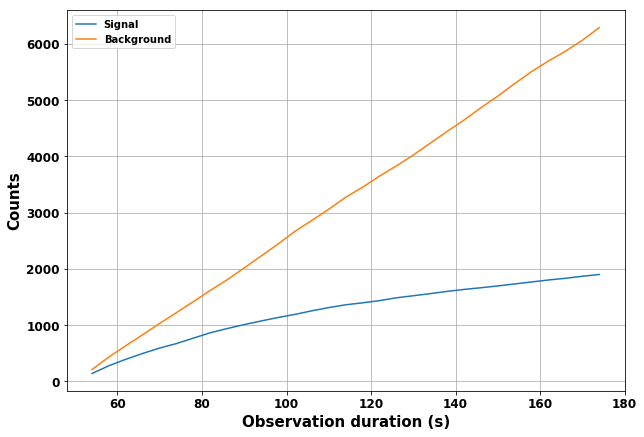

In [64]:
## Plot of an example
RedFact=1
LC_signal=smart.CubeLC(smart.CumulCube(smart.ReadCubeFromFile(output_dir+'CubeSignalReal_OneTrial_%s.fits'%(RedFact),fich_type="fits")[0]))
LC_bkg=smart.CubeLC(smart.CumulCube(smart.ReadCubeFromFile(output_dir+'CubeBkgReal_OneTrial_%s.fits'%(RedFact),"fits")[0]))

fig=plt.figure(figsize=(10,7))
ax=plt.axes()
ax.plot(T_new,LC_signal,label='Signal')
ax.plot(T_new,LC_bkg,label='Background')
ax.set_ylabel('Counts')
ax.set_xlabel('Observation duration (s)')
plt.legend()
plt.savefig('./Signal_and_bkg_evolution.png')


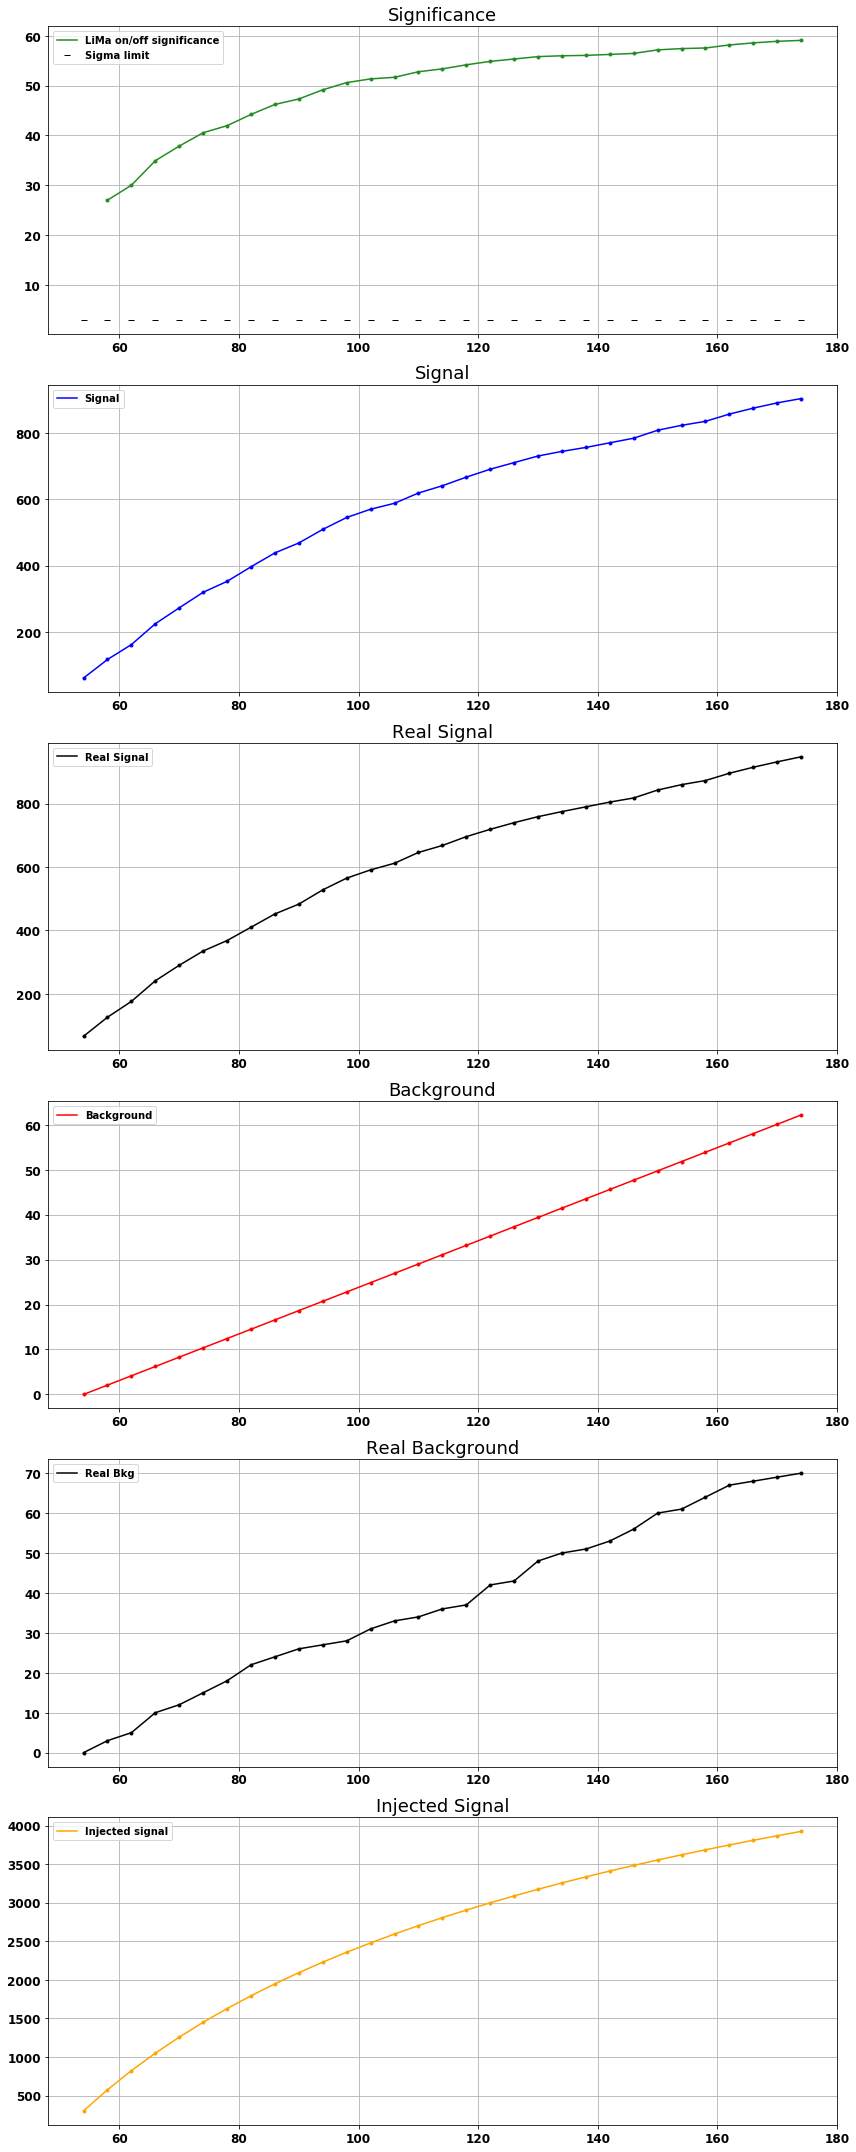

Alpha =  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [75]:
##Diagnostic Plot

RedFact=2

p=0


#Signif,Non,Noff,Alpha=ReflectedSignif[RedFact],ReflectedNon[RedFact],ReflectedNoff[RedFact],ReflectedAlpha[RedFact]
#Signif,Non,Noff,Alpha=RingSignif[RedFact],RingNon[RedFact],RingNoff[RedFact],RingAlpha[RedFact]
#Signif,Non,Noff,Alpha=AcSignif[RedFact],AcNon[RedFact],AcNoff[RedFact],AcAlpha[RedFact]
Signif,Non,Noff,Alpha=ModelSignif[RedFact],ModelNon[RedFact],ModelNoff[RedFact],ModelAlpha[RedFact]
#Signif,Non,Noff,Alpha=WaveSignif[RedFact,p],WaveNon[RedFact,p],WaveNoff[RedFact,p],WaveAlpha[RedFact,p]

#print('Command = %s, RedFact = %f'%(CommandList[p],RedFact))

LC=smart.CubeLC(smart.CumulCube(smart.CreateSignalModelCube(LC_new,RedFact,xcenter,ycenter,sigmaX,sigmaY,n2Dsize,pixelsize,Acceptance)))
RealSignal=smart.CubeLC(smart.CumulCube(smart.ReadCubeFromFile(output_dir + 'CubeSignalReal_OneTrial_%s.fits'%(RedFact),"fits")[0]))
RealBkgCube=smart.SepSourceBkgCube(Cube=smart.ReadCubeFromFile(output_dir + 'CubeBkgReal_OneTrial_%s.fits'%(RedFact),"fits")[0],\
                        x=n2Dsize/2,y=n2Dsize/2,theta=ct95/pixelsize)[1]
RealBkg=smart.CubeLC(smart.CumulCube(RealBkgCube))

shape=(12,30)
DiagnosticPlot(SigmaLim=3,T_new=T_new,LC_Src=LC,Signif=Signif,Non=Non,Noff=Noff,Alpha=Alpha,RealSignal=RealSignal,RealBackground=RealBkg,shape=shape)

## PyWI

In [112]:
RedFact=50
smart.PlotCubeImage(Tbin=4,cube_image=CubeC[RedFact],dbg=2,message='',t_diplay=T_new[-1],timearr=T_new)
#help(pywi.processing.compositing.filter_with_starlet.clean_image)

interactive(children=(IntSlider(value=114, description='tdisplay', max=174, min=54, step=4), Output()), _dom_c…

Pywi



interactive(children=(IntSlider(value=114, description='tdisplay', max=174, min=54, step=4), Output()), _dom_c…

plane 0



interactive(children=(IntSlider(value=114, description='tdisplay', max=174, min=54, step=4), Output()), _dom_c…

plane 1



interactive(children=(IntSlider(value=114, description='tdisplay', max=174, min=54, step=4), Output()), _dom_c…

plane 2



interactive(children=(IntSlider(value=114, description='tdisplay', max=174, min=54, step=4), Output()), _dom_c…

Real Source



interactive(children=(IntSlider(value=114, description='tdisplay', max=174, min=54, step=4), Output()), _dom_c…

FOV



interactive(children=(IntSlider(value=114, description='tdisplay', max=174, min=54, step=4), Output()), _dom_c…

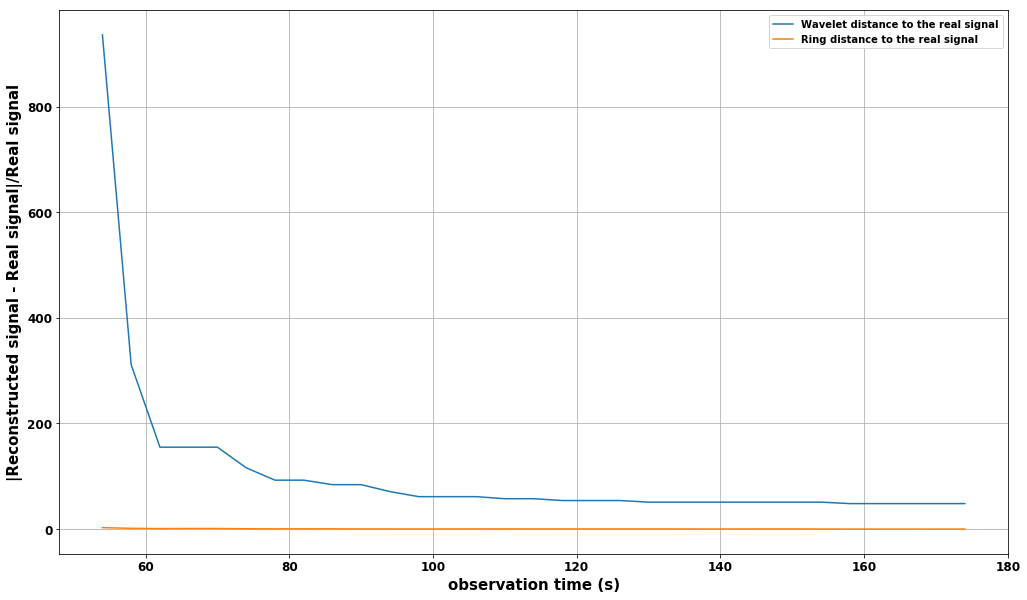

In [115]:
RedFact=80


shape=np.shape(Cube[RedFact])
WaveFilt=np.zeros(shape)
WaveTest0=np.zeros(shape)
WaveTest1=np.zeros(shape)
WaveTest2=np.zeros(shape)


for i in range(len(T_new)):
    img=CubeC[RedFact][:,:,i]
    smart.WriteCubeToFile(cube=img,filename='./Wave2D.fits',hdr='')
    wt_imgs = starlet.wavelet_transform(img, number_of_scales=3)
    WaveFilt[:,:,i]=pywi.processing.compositing.filter_with_starlet.clean_image(img,type_of_filtering='ksigma_hard_filtering',\
                        filter_thresholds=[100,1],last_scale_treatment='mask',detect_only_positive_structures=True,kill_isolated_pixels=False)      
    
    #wt_imgs[0][np.where(WaveFilt[:,:,i]==0)]=0
    #wt_imgs[1][np.where(WaveFilt[:,:,i]==0)]=0
    #wt_imgs[2][np.where(WaveFilt[:,:,i]==0)]=0
    #
    WaveTest0[:,:,i]=wt_imgs[0]
    WaveTest1[:,:,i]=wt_imgs[1]
    WaveTest2[:,:,i]=wt_imgs[2]
    #WavCleaning2D(command='-n4 -F2 -s3 -m2 -C1 -r -K -P -k -v',cube_noisy_file='./Wave2D.fits',wc_file='./Wave2D_Cleaned.fits')




print('Pywi')
#Plot3DCubeInteractive(Cube=WaveFilt,T_new=T_new,figuresize=(15,10),npixels=n2Dsize)
smart.PlotCubeImage(Tbin=4,cube_image=WaveFilt,dbg=2,message='',t_diplay=T_new[-1],timearr=T_new)

print('plane 0')
#Plot3DCubeInteractive(Cube=WaveTest0,T_new=T_new,figuresize=(15,10),npixels=n2Dsize)
smart.PlotCubeImage(Tbin=4,cube_image=WaveTest0,dbg=2,message='',t_diplay=T_new[-1],timearr=T_new)

print('plane 1')
#Plot3DCubeInteractive(Cube=WaveTest1,T_new=T_new,figuresize=(15,10),npixels=n2Dsize)
smart.PlotCubeImage(Tbin=4,cube_image=WaveTest1,dbg=2,message='',t_diplay=T_new[-1],timearr=T_new)

print('plane 2')
#Plot3DCubeInteractive(Cube=WaveTest2,T_new=T_new,figuresize=(15,10),npixels=n2Dsize)
smart.PlotCubeImage(Tbin=4,cube_image=WaveTest2,dbg=2,message='',t_diplay=T_new[-1],timearr=T_new)

print('Real Source')
#Plot3DCubeInteractive(Cube=smart.CumulCube(smart.ReadCubeFromFile(output_dir + 'CubeSignalReal_OneTrial_%s.fits'%(RedFact),"fits")[0]),T_new=T_new,figuresize=(15,10),npixels=n2Dsize)
smart.PlotCubeImage(Tbin=4,cube_image=smart.CumulCube(smart.ReadCubeFromFile(output_dir + 'CubeSignalReal_OneTrial_%s.fits'%(RedFact),"fits")[0]),dbg=2,message='',t_diplay=T_new[-1],timearr=T_new)
print('FOV')
#Plot3DCubeInteractive(Cube=CubeC[RedFact],T_new=T_new,figuresize=(15,10),npixels=n2Dsize)
smart.PlotCubeImage(Tbin=4,cube_image=CubeC[RedFact],dbg=2,message='',t_diplay=T_new[-1],timearr=T_new)


pixel_max=SearchMax(WaveFilt)
x,y=np.full(len(T_new),22),np.full(len(T_new),22)



Wave = Cube2DAnalyse(WaveFilt,method='ROI vs FOV',T_new=T_new,xsrc=x,ysrc=y)      
SignifW,NonW,NoffW,AlphaW = Wave[0],Wave[1],Wave[2],Wave[3]
Ring=Cube2DAnalyse(CubeC[RedFact],method='ring',T_new=T_new,xsrc=x,ysrc=y) 
Signif,Non,Noff,Alpha = Ring[0],Ring[1],Ring[2],Ring[3]


LC=smart.CubeLC(smart.CumulCube(smart.CreateSignalModelCube(LC_new,RedFact,x[0],y[0],sigmaX,sigmaY,n2Dsize,pixelsize,Acceptance)))
RealSignal=smart.CubeLC(smart.CumulCube(smart.ReadCubeFromFile(output_dir + 'CubeSignalReal_OneTrial_%s.fits'%(RedFact),"fits")[0]))
RealBkgCube=smart.SepSourceBkgCube(Cube=smart.ReadCubeFromFile(output_dir + 'CubeBkgReal_OneTrial_%s.fits'%(RedFact),"fits")[0],theta=2,x=n2Dsize/2,y=n2Dsize/2)[1]
RealBkg=smart.CubeLC(smart.CumulCube(RealBkgCube))


shape=(15,30)
fig,ax=plt.subplots(figsize=(17,10))
ax.plot(T_new,abs(np.array(Wave[1])-np.array(Wave[3])*np.array(Wave[2])-RealSignal)/RealSignal,label='Wavelet distance to the real signal')
ax.plot(T_new,abs(Ring[1]-Ring[3]*Ring[2]-RealSignal)/RealSignal,label='Ring distance to the real signal')
ax.set_xlabel('observation time (s)')
ax.set_ylabel('|Reconstructed signal - Real signal|/Real signal')
ax.legend()
plt.show()
